In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Radar Cross Section (RCS) of a Corner Reflector

## Introduction

This notebook demonstrates RCS analysis of a **corner reflector**—a specialized radar target designed to produce a strong, predictable radar return. Corner reflectors are fundamental calibration targets and reference objects in radar testing and measurement.

### What is a Corner Reflector?

A **corner reflector** (also called a trihedral reflector) consists of three mutually perpendicular flat conducting surfaces forming a corner. This geometry creates a unique property: incident radar waves undergo **triple-bounce reflections**, returning directly back to the source over a wide range of incident angles.

**Key Properties:**

1. **Retroreflection**: Reflects signals directly back to the source (monostatic geometry)
2. **Large RCS**: Provides significantly enhanced radar return compared to flat plates
3. **Wide Angular Response**: Maintains high RCS over a broad angular range
4. **Frequency Scalable**: RCS increases with frequency (proportional to f²)
5. **Polarization Preserving**: Maintains incident wave polarization after triple bounce

### Theoretical RCS Formula

For a trihedral corner reflector with edge length $a$, the theoretical maximum RCS is:

$$\sigma_{max} = \frac{4\pi a^4}{3\lambda^2}$$

Where:
- $\sigma_{max}$ = Maximum RCS (m²)
- $a$ = Edge length of the corner reflector (m)
- $\lambda$ = Radar wavelength (m)

**Key observations:**
- RCS proportional to $a^4$ (edge length to the fourth power)
- RCS proportional to $f^2$ (frequency squared, since λ = c/f)
- Independent of polarization for ideal retroreflection

### Applications

**Radar Calibration:**
- Reference targets for RCS measurement ranges
- Gain and pointing calibration of radar systems
- Verification of radar equation and system performance

**Navigation and Marking:**
- Marine navigation aids (radar beacons for buoys)
- SAR (Synthetic Aperture Radar) ground control points
- Landing zone markers for aircraft

**Radar Testing:**
- Controlled target returns for algorithm validation
- Point target simulation for imaging radar testing
- Performance verification in controlled environments

**Military Applications:**
- Decoys and deception systems
- Training targets for weapon systems
- False target generation

### Corner Reflector Types

| Type | Geometry | Characteristics |
|------|----------|-----------------|
| **Triangular (Trihedral)** | 3 perpendicular plates | Maximum RCS, omnidirectional |
| **Square** | 4 plates forming pyramid | Moderate RCS, directional |
| **Luneburg Lens** | Dielectric sphere | Wideband, spherical response |
| **Dihedral** | 2 perpendicular plates | High RCS in one plane only |

### You'll Learn How To:

- Load and visualize corner reflector 3D models
- Simulate RCS versus frequency (1-79 GHz range)
- Analyze frequency-dependent behavior and validate theoretical predictions
- Compute RCS versus observation angle to characterize angular response
- Understand the relationship between geometry and retroreflective properties
- Compare simulation results with analytical formulas
- Apply corner reflectors for radar system calibration

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate a corner reflector's RCS across:

1. **Frequency sweep**: 1-79 GHz to observe the f² dependence
2. **Angular sweep**: -90° to +90° azimuth to characterize beamwidth

We'll use RadarSimPy's **ray tracing** and **physical optics (PO)** methods to accurately model the triple-bounce reflections that create the corner reflector's distinctive signature.

## 3D Model Loading

Load the corner reflector geometry using PyMeshLab. The model represents a trihedral corner reflector with three perpendicular conducting surfaces.

### Model Configuration

Define the target with its 3D model file and coordinate system.

In [2]:
# Import necessary libraries for mesh processing and numerical operations
import pymeshlab
import numpy as np

# Define corner reflector target configuration
target = {
    "model": "../models/cr.stl",  # Path to corner reflector 3D model
    "unit": "m",                   # Model units (meters)
    "location": (0, 0, 0),         # Target position at origin (x, y, z)
}

### Visualize 3D Model

Display the corner reflector geometry to verify the trihedral structure. The three mutually perpendicular plates form the characteristic corner that enables retroreflection.

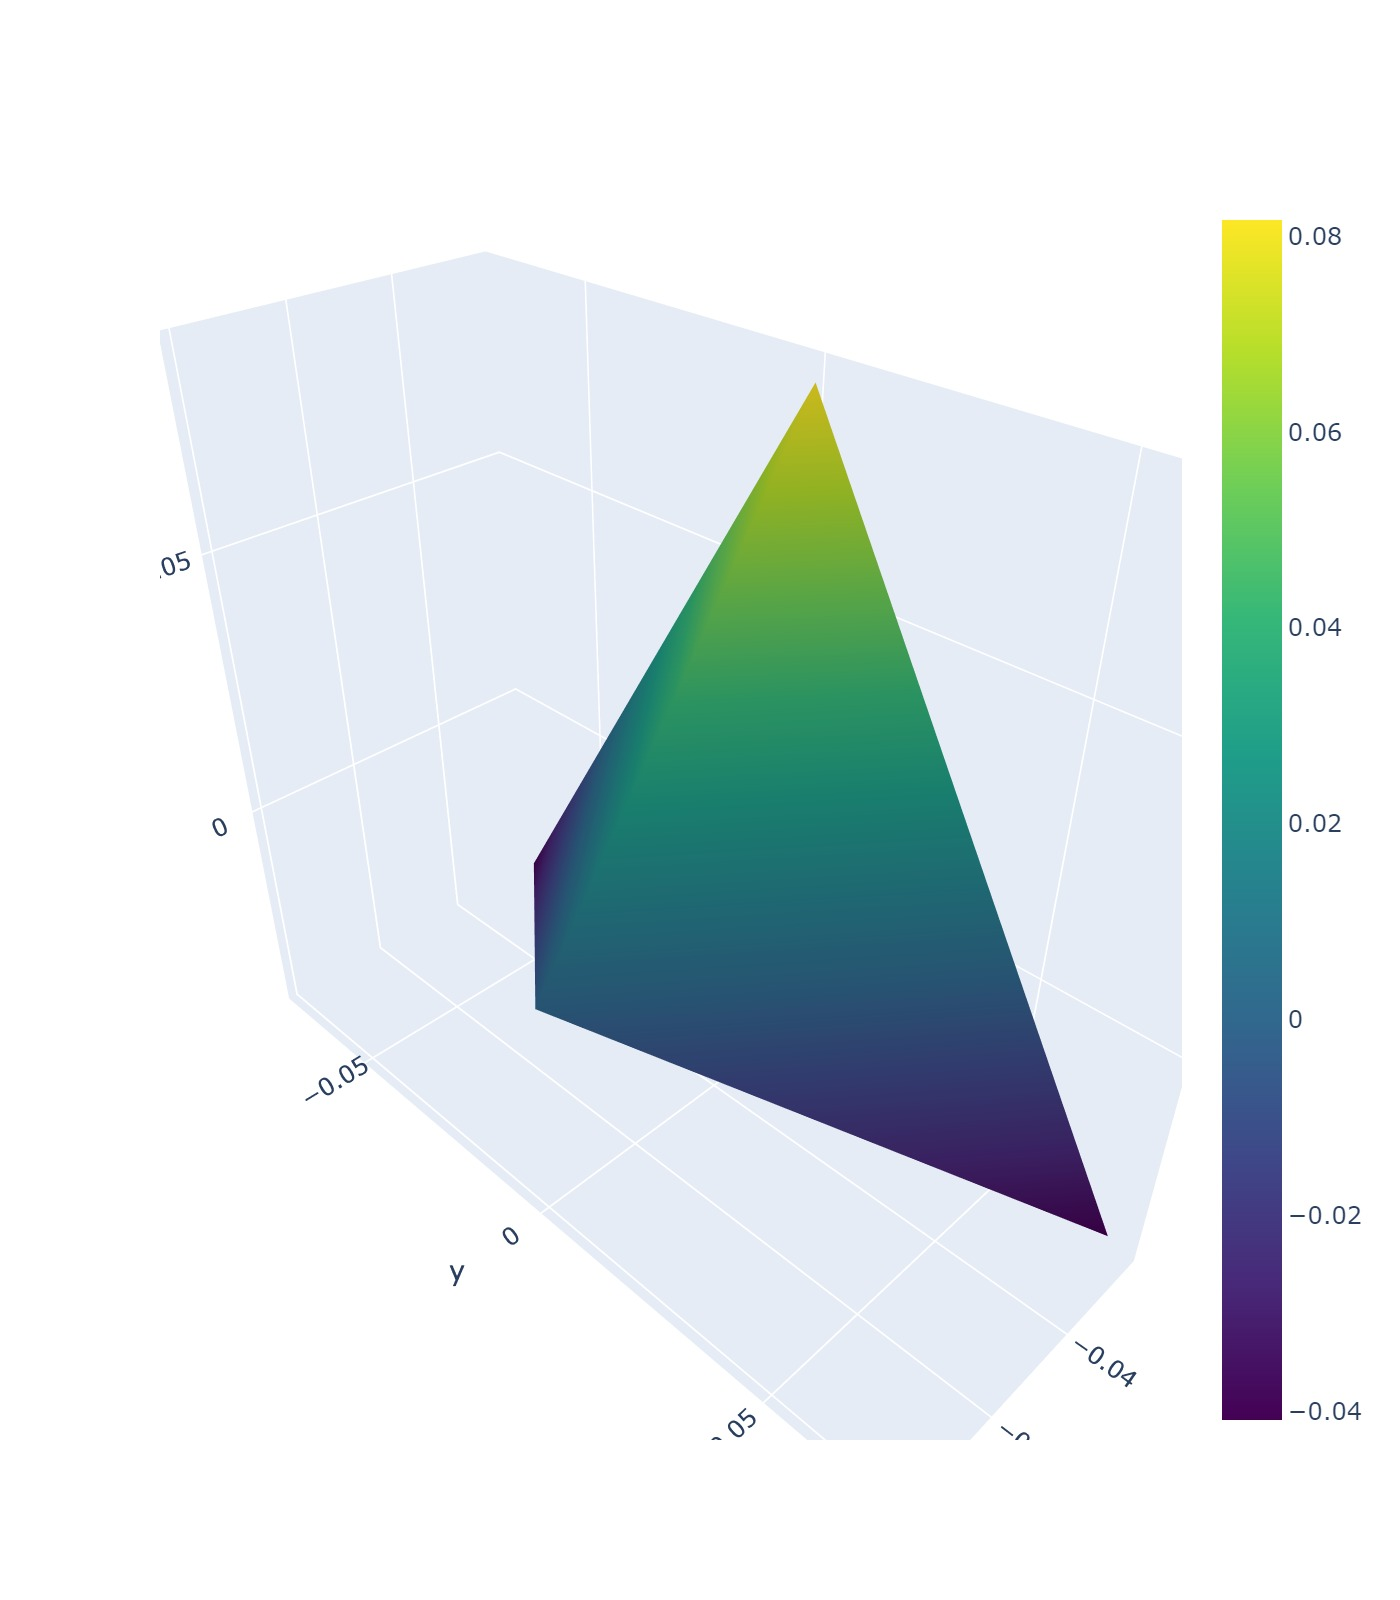

In [3]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Load 3D mesh using PyMeshLab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())    # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=v_matrix[:, 2],        # Z coordinates
        i=f_matrix[:, 0],        # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",      # Color scheme
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## RCS Simulation vs Frequency

Analyze how the corner reflector's RCS varies with frequency to validate the theoretical f² dependence and understand broadband performance.

### Simulation Parameters

**Observation Geometry:**
- **Azimuth (φ)**: 0° (boresight, looking directly into the corner)
- **Elevation (θ)**: 90° (horizontal plane)
- **Fixed orientation**: Optimal retroreflection angle

**Frequency Range:**
- **Range**: 1 GHz to 79 GHz
- **Resolution**: 1 GHz steps
- **Coverage**: L-band through W-band (automotive radar)

**Radar Configuration:**
- **Polarization**: Horizontal [0, 1, 0]
- **Ray Density**: 10 rays per wavelength² (high accuracy)

**Expected Behavior:**
- RCS should increase approximately as f² (20 dB per decade)
- Higher frequencies → shorter wavelengths → larger electrical size
- Theoretical formula: σ ∝ a⁴/λ² ∝ f²

### Run Frequency Sweep

Compute RCS for each frequency point. This loop-based approach allows frequency-dependent ray density optimization.

In [4]:
# Import time module for performance measurement
import time

# Import RCS simulation function
from radarsimpy.simulator import sim_rcs

# Define observation angles (boresight configuration)
phi = 0        # Azimuth: 0° (looking into corner)
theta = 90     # Elevation: 90° (horizontal plane)

# Frequency sweep parameters
freq = np.arange(1, 79, 1) * 1e9  # 1-79 GHz in 1 GHz steps

# Radar configuration
pol = [0, 1, 0]  # Horizontal polarization
density = 10     # High ray density for accuracy (10 rays per λ)

# Initialize RCS array
rcs = np.zeros_like(freq)

# Start timing
tic = time.time()

# Compute RCS for each frequency
for f_idx, f in enumerate(freq):
    # Simulate RCS and convert to dBsm
    rcs[f_idx] = 10 * np.log10(sim_rcs([target], f, phi, theta, pol, density=density))

# End timing
toc = time.time()

# Display execution time
print("Exec time: " + str(toc - tic) + " s")

Exec time: 3.7554502487182617 s


### Visualize RCS vs Frequency

Plot the frequency-dependent RCS to observe the characteristic f² growth trend.

**Analysis Points:**
- **Slope**: Should approach 20 dB/decade (10×frequency → 100×RCS → +20 dB)
- **Low Frequencies**: RCS may deviate from theoretical at very low frequencies
- **High Frequencies**: Better agreement with physical optics approximation
- **Practical Use**: Helps select optimal frequency for calibration applications

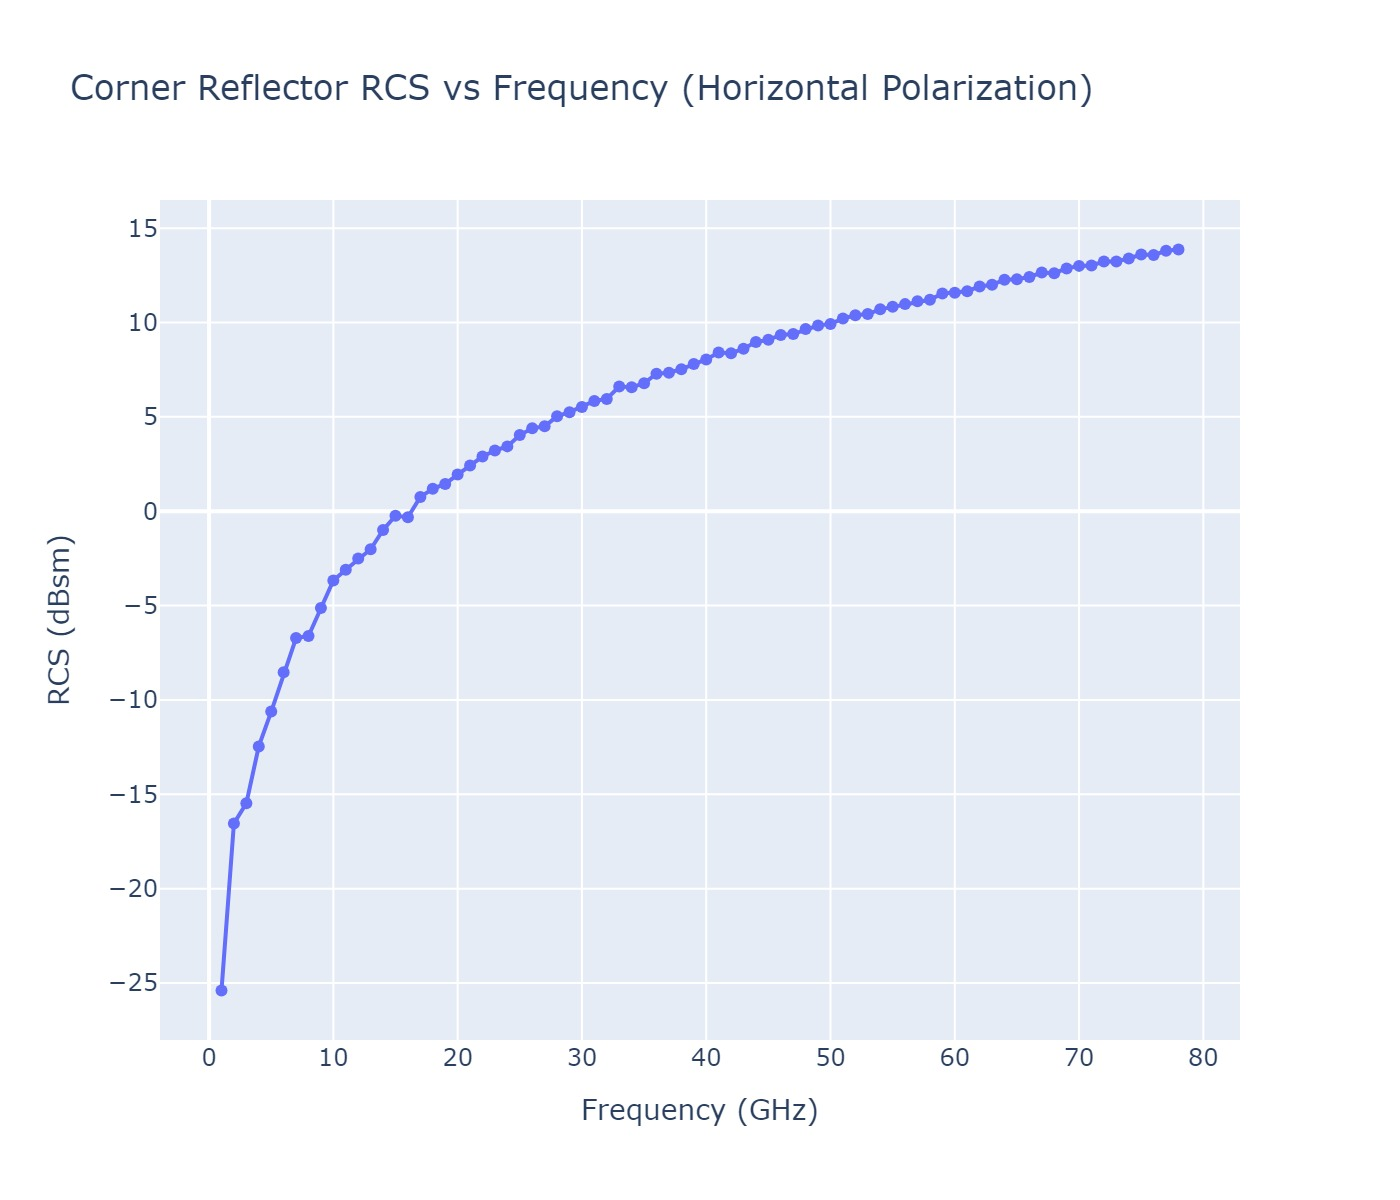

In [5]:
# Create figure for RCS vs frequency plot
fig = go.Figure()

# Plot RCS as function of frequency
fig.add_trace(go.Scatter(
    x=freq / 1e9,  # Convert to GHz for display
    y=rcs,
    mode='lines+markers',
    name='Simulated RCS'
))

# Configure plot layout
fig.update_layout(
    title="Corner Reflector RCS vs Frequency (Horizontal Polarization)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Frequency (GHz)", dtick=10),
    height=600,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## RCS Simulation vs Observation Angle

Characterize the angular response of the corner reflector to understand its retroreflective beamwidth and directional properties.

### Simulation Parameters

**Observation Geometry:**
- **Azimuth (φ)**: -90° to +90° in 0.5° steps
- **Elevation (θ)**: Fixed at 90° (horizontal sweep)
- **Angular coverage**: 180° sector

**Radar Parameters:**
- **Frequency**: 77 GHz (automotive radar W-band)
- **Wavelength**: ~3.9 mm
- **Polarization**: Vertical [0, 0, 1]

**Computation Settings:**
- **Ray Density**: 1 ray per wavelength² (balanced accuracy/speed)

**Expected Pattern:**
- **Peak RCS**: At 0° (boresight, direct retroreflection)
- **3-dB Beamwidth**: Typically 40-60° for trihedral reflectors
- **Rapid Falloff**: RCS drops quickly outside main lobe
- **Symmetry**: Should be symmetric about 0° azimuth

### Run Angular Sweep

Compute RCS across all observation angles in a single efficient call.

In [6]:
# Define angular sweep parameters
phi = np.arange(-90, 90, 0.5)    # Azimuth angles: -90° to +90° in 0.5° steps
theta = np.zeros_like(phi) + 90   # Elevation: fixed at 90° (horizontal plane)

# Radar configuration for angular analysis
freq = 77e9       # Operating frequency: 77 GHz (automotive radar)
pol = [0, 0, 1]   # Vertical polarization
density = 1       # Ray density: 1 ray per λ² (faster computation)

# Start timing
tic = time.time()

# Simulate RCS for all observation angles
# Single function call is more efficient than loop
rcs = 10 * np.log10(sim_rcs([target], freq, phi, theta, pol, density=density))

# End timing
toc = time.time()

# Display execution time
print("Exec time: " + str(toc - tic) + " s")

Exec time: 0.29958391189575195 s


### Visualize Angular Response Pattern

Plot the RCS pattern versus observation angle to reveal the corner reflector's directional characteristics.

**Key Features to Observe:**
- **Maximum RCS**: Occurs at 0° (boresight alignment)
- **Beamwidth**: Measure the angular width where RCS remains within 3 dB of peak
- **Side Lobes**: Secondary peaks may appear due to edge diffraction
- **Symmetry**: Pattern should be symmetric due to corner geometry
- **Falloff Rate**: How quickly RCS decreases with angle (important for field-of-view)

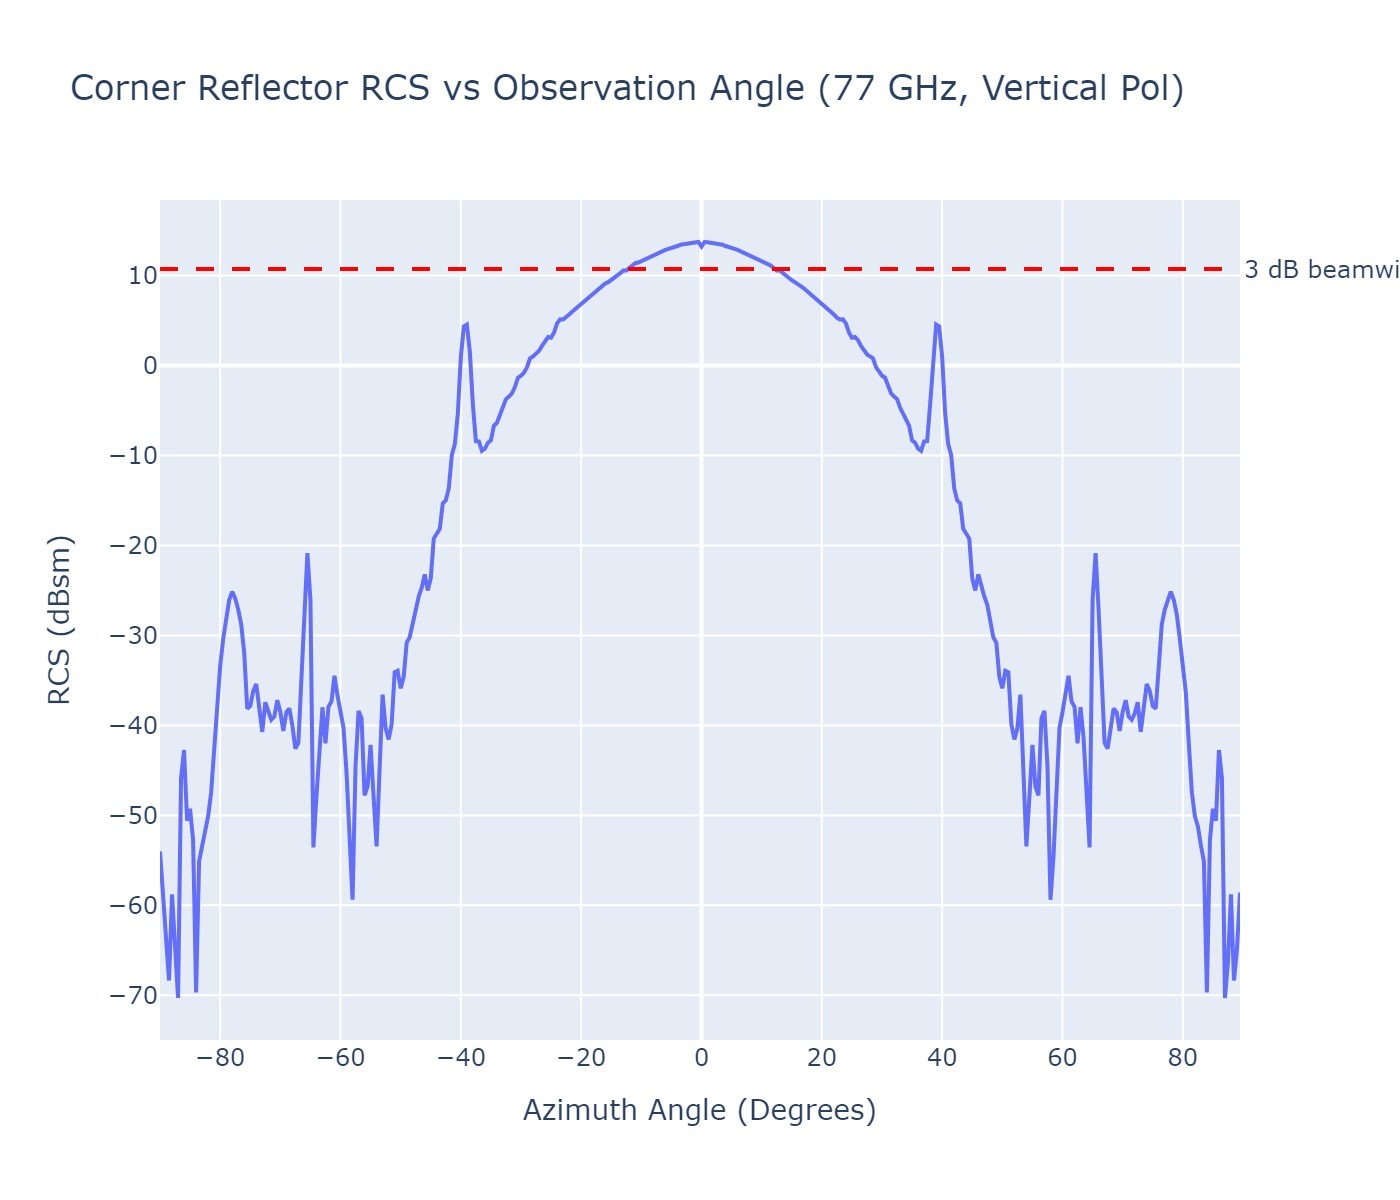

In [8]:
# Create figure for angular RCS pattern
fig = go.Figure()

# Plot RCS vs azimuth angle
fig.add_trace(go.Scatter(
    x=phi,
    y=rcs,
    mode='lines',
    name='RCS Pattern'
))

# Add reference line at peak RCS - 3dB for beamwidth measurement
max_rcs = np.max(rcs)
fig.add_hline(
    y=max_rcs - 3,
    line_dash="dash",
    line_color="red",
    annotation_text="3 dB beamwidth",
    annotation_position="right"
)

# Configure plot layout
fig.update_layout(
    title="Corner Reflector RCS vs Observation Angle (77 GHz, Vertical Pol)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Azimuth Angle (Degrees)", dtick=20),
    height=600,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to simulate and analyze the Radar Cross Section of a corner reflector using RadarSimPy:

### Key Takeaways

**1. Corner Reflector Fundamentals**
- Understood trihedral geometry and retroreflective properties
- Learned about triple-bounce reflections returning signals to source
- Explored theoretical RCS formula: σ ∝ a⁴/λ² ∝ f²
- Recognized applications in calibration, navigation, and radar testing

**2. Frequency-Dependent Behavior**
- Simulated RCS across 1-79 GHz (L-band through W-band)
- Observed the characteristic f² (20 dB/decade) frequency dependence
- Validated physical optics approximation for electrically large targets
- Understood wavelength effects on effective aperture

**3. Angular Response Characteristics**
- Characterized the corner reflector's directional pattern
- Measured retroreflective beamwidth (typically 40-60°)
- Observed symmetric response about boresight axis
- Analyzed rapid RCS falloff outside main lobe

**4. Simulation Techniques**
- Used high ray density (10 rays/λ²) for frequency sweep accuracy
- Balanced accuracy vs. speed with lower density (1 ray/λ²) for angular sweep
- Applied both loop-based and vectorized simulation approaches
- Demonstrated timing and performance measurement

**5. Practical Insights**
- Corner reflectors provide stable, predictable reference targets
- RCS increases dramatically with frequency (useful for high-frequency calibration)
- Wide beamwidth enables easier alignment in field deployments
- Polarization-preserving property simplifies measurement setups

### Experiment Further

Try modifying the parameters to explore different scenarios:

1. **Geometric Variations**:
   - Scale the corner reflector (larger/smaller edge length)
   - Calculate theoretical RCS using σ = 4πa⁴/(3λ²)
   - Compare simulated vs. theoretical maximum RCS

2. **Frequency Analysis**:
   - Extend to higher frequencies (94 GHz, 140 GHz)
   - Test lower frequencies (UHF band: 300 MHz - 3 GHz)
   - Plot RCS on log-log scale to verify f² slope

3. **Polarization Studies**:
   - Test both horizontal and vertical polarization
   - Try circular polarization combinations
   - Verify polarization preservation property

4. **Angular Characterization**:
   - Measure 3-dB beamwidth from angular pattern
   - Create 2D angular pattern (vary both φ and θ)
   - Generate polar plots for intuitive visualization

5. **Ray Density Optimization**:
   - Compare results with density = 0.5, 1, 5, 10
   - Analyze accuracy vs. computation time trade-off
   - Determine minimum density for acceptable accuracy

6. **Multi-Target Scenarios**:
   - Simulate multiple corner reflectors at different positions
   - Analyze combined RCS patterns
   - Test as calibration array for imaging radar

7. **Comparison Studies**:
   - Compare corner reflector vs. flat plate RCS
   - Test dihedral (2-plate) vs. trihedral (3-plate) reflectors
   - Analyze sphere vs. corner reflector patterns

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- PyMeshLab Documentation: https://pymeshlab.readthedocs.io/
- Corner Reflector Theory: Electromagnetic scattering and retroreflection
- Radar Calibration: Reference target design and measurement techniques
- Physical Optics: High-frequency scattering approximations
- RCS Measurement: Outdoor and anechoic chamber testing standards